In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
if os.getcwd().split("/")[-1] != 'BENDR-XAI': os.chdir("../")

from scipy.stats import ttest_ind, mannwhitneyu
import datetime
import seaborn as sns 
import pandas as pd
from statsmodels.stats.multitest import multipletests

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def is_random_concept(concept, random_counterpart=None, random_concepts=None):
    if random_counterpart:
        return random_counterpart == concept

    elif random_concepts:
        return concept in random_concepts

    else:
        return 'random500_' in concept

def summarize_results(results):
    summary = {}
    random_results = {}

    for result in results:
        concept = result['cav_concept']
        bottleneck = result['bottleneck']

        if concept not in summary:
            summary[concept] = {}
        if bottleneck not in summary[concept]:
            summary[concept][bottleneck] = []

        summary[concept][bottleneck].append(result)

        if is_random_concept(concept):
            if bottleneck not in random_results:
                random_results[bottleneck] = []

            random_results[bottleneck].append(result['i_up'])

    return summary, random_results

def get_tcav_results(summary, random_results, alpha=0.05, correction=True):
    columns = ['concept', 'bottleneck', 'score', 'random_score', 'p_value', 'significant']
    results_df = pd.DataFrame(columns=columns)

    for concept in summary:
        if not is_random_concept(concept):
            for bottleneck in summary[concept]:
                scores = [item['i_up'] for item in summary[concept][bottleneck]]
                _, p_val = mannwhitneyu(random_results[bottleneck], scores)
                significant = p_val <= alpha
                data = {'concept': concept, 'bottleneck': bottleneck,
                        'score': np.mean(scores), 'random_score': np.mean(random_results[bottleneck]),
                        'p_value': p_val, 'significant': significant}
                results_df = pd.concat([results_df, pd.DataFrame(data, index=[0])], ignore_index=True)
    
    if correction:
        results_df['p_value'] = multipletests(results_df['p_value'], alpha=alpha, method='bonferroni')[1]
            
        tmp = np.empty(len(results_df), dtype=bool)    
        for i in range(len(results_df)):
            tmp[i] = results_df['p_value'][i] <= alpha
        results_df['significant'] = tmp

    return results_df

def merge_left_right_results(df):
    output_df = pd.DataFrame(columns=['concept', 'bottleneck', 'lh_score', 'rh_score', 'random_score', 'lh_p', 'rh_p'])
    
    assert all([concept.endswith('-lh') or concept.endswith('-rh') for concept in df['concept'].unique()])

    for row in df[df['concept'].str.endswith('-lh')].itertuples():
        row_dict = row._asdict()
        concept_name = row_dict['concept'][:-3]
        bottleneck = row_dict['bottleneck']
        lh_score = row_dict['score']
        lh_p = row_dict['p_value']
        lh_random_score = row_dict['random_score']

        rh_row = df[(df['concept'] == concept_name + '-rh') & (df['bottleneck'] == bottleneck)]
        
        if len(rh_row) == 0:
            print("No right hemisphere result for", concept_name, bottleneck)
            continue
        elif len(rh_row) > 1:
            print("More than one right hemisphere result for", concept_name, bottleneck)
            assert False
        
        rh_score = rh_row['score'].values[0]
        rh_p = rh_row['p_value'].values[0]
        rh_random_score = rh_row['random_score'].values[0]
    
        assert lh_random_score == rh_random_score

        data = {'concept': concept_name, 'bottleneck': bottleneck,
                'lh_score': lh_score, 'rh_score': rh_score, 'random_score': lh_random_score,
                'lh_p': lh_p, 'rh_p': rh_p}
        
        output_df = pd.concat([output_df, pd.DataFrame(data, index=[0])], ignore_index=True)

    return output_df

def move_left_right_to_colomn(df):
    columns = ['concept', 'bottleneck', 'score', 'random_score', 'p_value', 'significant', 'hemi']
    output_df = pd.DataFrame(columns=columns)
    
    assert all([concept.endswith('-lh') or concept.endswith('-rh') for concept in df['concept'].unique()])
    
    for row in df.itertuples():
        row_dict = row._asdict()
        
        concept_name = row_dict['concept'][:-3]
        bottleneck = row_dict['bottleneck']
        score = row_dict['score']
        random_score = row_dict['random_score']
        p_value = row_dict['p_value']
        significant = row_dict['significant']
        hemi = row_dict['concept'][-2:]       
        
        data = {'concept': concept_name, 'bottleneck': bottleneck,
                'score': score, 'random_score': random_score,
                'p_value': p_value, 'significant': significant, 'hemi': hemi}
        
        output_df = pd.concat([output_df, pd.DataFrame(data, index=[0])], ignore_index=True)
        
    return output_df
                
def present_results(result_summary, random_i_ups, min_p_val=0.05):
    for concept in result_summary:

        # if not random
        if not is_random_concept(concept):
            print(" ", "Concept =", concept)

            for bottleneck in result_summary[concept]:
                i_ups = [item['i_up'] for item in result_summary[concept][bottleneck]]

                # Calculate statistical significance
                _, p_val = ttest_ind(random_i_ups[bottleneck], i_ups)

                print(3 * " ", "Bottleneck =", ("%s. TCAV Score = %.2f (+- %.2f), "
                                                "random was %.2f (+- %.2f). p-val = %.3f (%s)") % (
                        bottleneck, np.mean(i_ups), np.std(i_ups),
                        np.mean(random_i_ups[bottleneck]),
                        np.std(random_i_ups[bottleneck]), p_val,
                        "not significant" if p_val > min_p_val else "significant"))

In [3]:
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.pylab as plt
from matplotlib.ticker import AutoMinorLocator

def plot_tcav_left_right(df, ax, title='TCAV scores for each concept and bottleneck'):

    def format_string(s):
        if len(s) > 20 and ' ' in s:
            space_idxs = [i for i, c in enumerate(s) if c == ' ']
            return s[:space_idxs[len(space_idxs)//2]] + '\n' + s[space_idxs[len(space_idxs)//2]+1:]
        else:
            return s

    color_map = [
    (0.12, 0.47, 0.71),
    (1.00, 0.50, 0.05),
    (0.17, 0.63, 0.17),
    (0.84, 0.15, 0.16),
    (0.95, 0.90, 0.25), 
    ] #plt.get_cmap('tab10').colors

    positions = np.array([ 0. ,  2.5,  5. ,  7.5, 10. ])
    min_pos = -0.5
    max_pos = float('-inf')

    xticks = []

    # Hline at 0.5 behind bars
    ax.axhline(0.5, color=(0.75,0.75,0.75), linestyle='--', zorder=-1)
    

    for i, concept in enumerate(df['concept'].unique()):
        for j, bottleneck in enumerate(df[df['concept'] == concept]['bottleneck']):
            x = 15*i + positions[j]
            
            data = df[(df['concept'] == concept) & (df['bottleneck'] == bottleneck)]
            
            y1 = data['lh_score'].values[0]
            y2 = data['rh_score'].values[0]
            
            # Make two bars side by side with y1 and y2 values in different patterns
            ax.bar(x - 0.5, y1, width=1, color=color_map[j], edgecolor='k', hatch='xxx', zorder=2)
            ax.bar(x + 0.5, y2, width=1, color=color_map[j], edgecolor='k', hatch='...', zorder=2)
            
            lh_p = data['lh_p'].values[0]
            rh_p = data['rh_p'].values[0]
            
            # Add '*' above the bar if the score is significant
            if lh_p < 0.05:
                ax.text(x - 0.5, y1, '*', fontsize=10, horizontalalignment='center')
            if rh_p < 0.05:
                ax.text(x + 0.5, y2, '*', fontsize=10, horizontalalignment='center')        
            
            max_pos = max(max_pos, x + 0.5)        
            
        xticks.append(np.mean(15*i + positions))
        
    xtickslabels = df['concept'].unique()
    xtickslabels = [format_string(label.replace('Alpha_', '')) for label in xtickslabels]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtickslabels, rotation=0, fontsize=11)

    # Make legend with colors and bottlenecks names. Make it one row
    legend_elements = [Patch(facecolor=color_map[i], edgecolor='k', label=bottleneck) for i, bottleneck in enumerate(df['bottleneck'].unique())]
    legend1 = plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1), ncol=5, fontsize=10)
    legend1.get_frame().set_edgecolor('k')
    
    
    
    # Add an extra legend without removing the previous one
    legend_elements = [Patch(facecolor='w', edgecolor='k', hatch='xx', label='Left hemisphere'),
                        Patch(facecolor='w', edgecolor='k', hatch='..', label='Right hemisphere')]
    legend2 = plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1), ncol=5, fontsize=10)
    legend2.get_frame().set_edgecolor('k')

    # Add both legends to the plot
    ax.add_artist(legend1)
    ax.add_artist(legend2)

    ax.set_ylim(0, 1.25)
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.set_ylabel('TCAV Score', fontsize=13)

    ax.set_xlim(min_pos - 1.5, max_pos + 1.5)
    
    ax.grid(axis='y', linestyle='--', color=(0.75,0.75,0.75), zorder=-1)

    minor_locator = AutoMinorLocator(2)
    plt.gca().xaxis.set_minor_locator(minor_locator)
    ax.grid(which='minor', linestyle='-', color=(0.75,0.75,0.75), zorder=-1)


    plt.suptitle(title, fontsize=13, fontweight='bold', y=.97)


def plot_tcav(df, ax, title="TCAV"):

    color_map = [
    (0.12, 0.47, 0.71),
    (1.00, 0.50, 0.05),
    (0.17, 0.63, 0.17),
    (0.84, 0.15, 0.16),
    (0.95, 0.90, 0.25), 
    ] #plt.get_cmap('tab10').colors
    
    hatches = ['///', '\\\\\\', '|||', '---', '+++']

    positions = np.array([ 0. ,  2.5,  5. ,  7.5, 10. ]) / 2
    min_pos = -0.5
    max_pos = float('-inf')

    xticks = []

    # Hline at 0.5 behind bars
    ax.axhline(0.5, color=(0.75,0.75,0.75), linestyle='--', zorder=-1)

    for i, concept in enumerate(df['concept'].unique()):
        for j, bottleneck in enumerate(df[df['concept'] == concept]['bottleneck']):
            x = 7.5*i + positions[j]
            
            data = df[(df['concept'] == concept) & (df['bottleneck'] == bottleneck)]
            y = data['score'].values[0]

            # Make two bars side by side with y1 and y2 values in different patterns
            ax.bar(x, y, width=1, color=color_map[j], edgecolor='k', hatch=hatches[j],  zorder=2)
            
            p_value = data['p_value'].values[0]
            
            # Add '*' above the bar if the score is significant
            if p_value < 0.05:
                ax.text(x, y, '*', fontsize=10, horizontalalignment='center')     
            
            max_pos = max(max_pos, x + 0.5)        
            
        xticks.append(np.mean(7.5*i + positions))
        
    xtickslabels = df['concept'].unique()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtickslabels, rotation=0, fontsize=11)

    # Make legend with colors and bottlenecks names. Make it one row
    legend_elements = [Patch(facecolor=color_map[i], edgecolor='k', label=bottleneck, hatch=hatches[i]) for i, bottleneck in enumerate(df['bottleneck'].unique())]
    legend1 = plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1), ncol=5, fontsize=9, columnspacing=1)
    legend1.get_frame().set_edgecolor('k')

    # Add both legends to the plot
    ax.add_artist(legend1)

    ax.set_ylim(0, 1.25)
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.set_ylabel('TCAV Score', fontsize=13)

    ax.set_xlim(min_pos - 0.75, max_pos + 0.75)
    
    ax.grid(axis='y', linestyle='--', color=(0.75,0.75,0.75), zorder=-1)

    minor_locator = AutoMinorLocator(2)
    plt.gca().xaxis.set_minor_locator(minor_locator)
    ax.grid(which='minor', linestyle='-', color=(0.75,0.75,0.75), zorder=-1)

    plt.suptitle(title, fontsize=13, fontweight='bold', y=.97)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


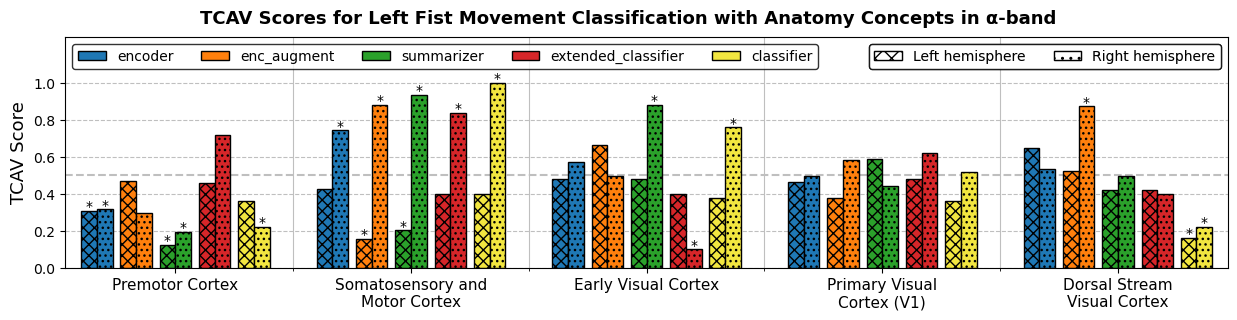

In [4]:
concept_order = ["Premotor Cortex", "Somatosensory and Motor Cortex", "Early Visual Cortex", "Primary Visual Cortex (V1)", "Dorsal Stream Visual Cortex"]
bottle_neck_order = ["encoder", "enc_augment", "summarizer", "extended_classifier", "classifier"]

data_path = r"data/tcav_results_0504124432826153_TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_215437_010523_50_big.pkl"
with open(data_path, 'rb') as f:
    results = pickle.load(f)
    
results = sorted(results, key=lambda k: k['cav_concept'])
results = [r for r in results if any([concept in r['cav_concept'] for concept in concept_order]) or 'random' in r['cav_concept']]

result_summary, random_i_ups = summarize_results(results)
df = get_tcav_results(*summarize_results(results), correction=True)

df_merge = merge_left_right_results(df)

# Create dictionaries to map the custom orders
concept_order_dict = {value: idx for idx, value in enumerate(concept_order)}
bottle_neck_order_dict = {value: idx for idx, value in enumerate(bottle_neck_order)}

# Add a 'concept_simple' column to your DataFrame with simplified names
df_merge['concept_simple'] = df_merge['concept'].str.extract(r'Alpha_(.*)')

# Sort DataFrame based on the custom orders
df_merge = df_merge.sort_values(
    by=['concept_simple', 'bottleneck'],
    key=lambda x: x.map(concept_order_dict).fillna(len(concept_order)) if x.name == 'concept_simple' else x.map(bottle_neck_order_dict)
)

# Remove the 'concept_simple' column as it's no longer needed
df_merge.drop(columns=['concept_simple'], inplace=True)
df_merge.reset_index(drop=True, inplace=True)


fig, ax = plt.subplots(figsize=(15, 3))

plot_tcav_left_right(df_merge, ax, title=r'TCAV Scores for Left Fist Movement Classification with Anatomy Concepts in α-band')

# Save figure in high quality as eps
plt.savefig('tcav_anatomy_alpha.eps', format='eps', dpi=2000, bbox_inches='tight')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


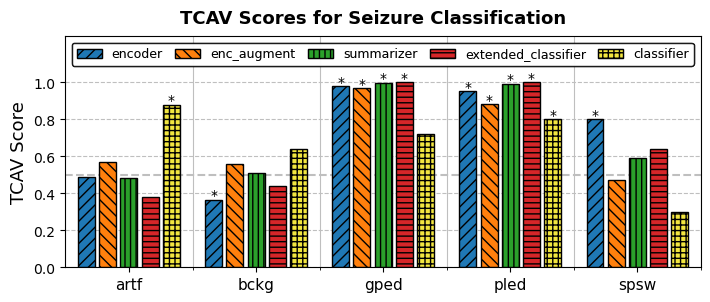

In [5]:
concept_order = ['artf', 'bckg', 'gped', 'pled', 'spsw']
bottle_neck_order = ["encoder", "enc_augment", "summarizer", "extended_classifier", "classifier"]

data_path = r"data/LinearHeadBendr19artRand50_target_Seiz_50_conceptsspswartfbckggpedbckgpled.pkl"
with open(data_path, 'rb') as f:
    results = pickle.load(f)
    
results = sorted(results, key=lambda k: k['cav_concept'])
result_summary, random_i_ups = summarize_results(results)

df = get_tcav_results(result_summary, random_i_ups, correction=True)
concept_order_dict = {value: idx for idx, value in enumerate(concept_order)}
bottle_neck_order_dict = {value: idx for idx, value in enumerate(bottle_neck_order)}

# Add a 'concept_simple' column to your DataFrame with simplified names
df['concept_simple'] = df['concept'].str.extract(r'Alpha_(.*)')

# Sort DataFrame based on the custom orders
df = df.sort_values(
    by=['concept_simple', 'bottleneck'],
    key=lambda x: x.map(concept_order_dict).fillna(len(concept_order)) if x.name == 'concept_simple' else x.map(bottle_neck_order_dict)
)

# Remove the 'concept_simple' column as it's no longer needed
df.drop(columns=['concept_simple'], inplace=True)
df.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(8.2, 3))
plot_tcav(df, ax, r"TCAV Scores for Seizure Classification")
plt.savefig('tcav_seizure.eps', format='eps', dpi=2000, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


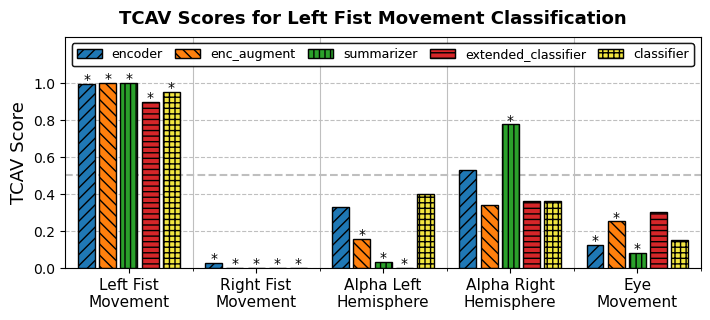

In [6]:
data_path = r"data/LinearHeadBendr_target_left_20_conceptsleft_MIright_MIeyemmusc50.pkl"
with open(data_path, 'rb') as f:
    results = pickle.load(f)
    
results = sorted(results, key=lambda k: k['cav_concept'])
results = [r for r in results if 'musc' not in r['cav_concept']]

df1 = get_tcav_results(*summarize_results(results), correction=True)

result_path = 'data/tcav_results_0504091104880446_left_right_concepts_MMIDB_25.pkl'

with open(result_path, 'rb') as f:
    results = pickle.load(f)
    
results = sorted(results, key=lambda k: k['cav_concept'])
results = [r for r in results if 'Alpha' in r['cav_concept'] or 'random' in r['cav_concept']]

df2 = get_tcav_results(*summarize_results(results))

df = pd.concat((df1, df2))

concept_order = ['left_MI', 'right_MI', 'Alpha_lh', 'Alpha_rh', 'eyem']
bottle_neck_order = ["encoder", "enc_augment", "summarizer", "extended_classifier", "classifier"]

concept_order_dict = {value: idx for idx, value in enumerate(concept_order)}
bottle_neck_order_dict = {value: idx for idx, value in enumerate(bottle_neck_order)}

df = df.sort_values(
    by=['concept', 'bottleneck'],
    key=lambda x: x.map(concept_order_dict).fillna(len(concept_order)) if x.name == 'concept' else x.map(bottle_neck_order_dict)
)

df.reset_index(drop=True, inplace=True)

new_names = {'Alpha_lh': 'Alpha Left\nHemisphere', 'Alpha_rh': 'Alpha Right\nHemisphere', 'left_MI': 'Left Fist\nMovement', 'right_MI': 'Right Fist\nMovement', 'eyem': 'Eye\nMovement', 'musc': 'Muscle'}
df['concept'] = df['concept'].replace(new_names)

fig, ax = plt.subplots(figsize=(8.2, 3))
plot_tcav(df, ax, r"TCAV Scores for Left Fist Movement Classification")
plt.savefig('tcav_left_fist.eps', format='eps', dpi=2000, bbox_inches='tight')
plt.show()